In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
# this file should be run from {caffe_root}/examples (otherwise change this line)
caffe_root = '/media/hermetico/2TB/frameworks/caffe/'  

activities_net = {
    'model': 'models/finetuning-googlenet/reference_activitiesnet.caffemodel',
    'deploy': 'models/finetuning-googlenet/deploy.prototxt'
}
# the paths for the labels and for the dataset
labels_path = os.path.join(caffe_root, 'data/daily_activities/labels.txt')
test_dataset_path = os.path.join(caffe_root, 'data/daily_activities/test.txt')
sys.path.insert(0, caffe_root + 'python')

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

/home/hermetico/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/media/hermetico/2TB/frameworks/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/media/hermetico/2TB/frameworks/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/media/hermetico/2TB/frameworks/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion metho

Loading the files

In [2]:
# dataset stuff
test_dataset = [ line.split(' ') 
                for line in list(np.loadtxt(test_dataset_path, str, delimiter='\n'))
                if len(line.split(' ')) == 2 # there are some images with wierd paths
               ]
test_paths, test_labels = zip(*[(path, int(label)) for path, label in test_dataset])
labels = list(np.loadtxt(labels_path, str, delimiter='\n'))
NUM_LABELS = len(labels)
print "%i labels loaded" % NUM_LABELS
print "%i test images" % (len(test_paths))

21 labels loaded
2796 test images


Loading the classifiar, and setting up the caffe preprocessor in order to load images one by one instead of by batches, it will be slower but we can play around with the data

In [3]:
# loads activities net 
activitiesnet = caffe.Classifier(activities_net['deploy'], activities_net['model'], caffe.TEST)
activitiesnet.blobs['data'].reshape(1,3,227,227)

# Preprocessing for caffe inputs
transformer = caffe.io.Transformer({'data': activitiesnet.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

Let's display a prediction to show that everything works

Label:  driving

Best prediction
85%: reading

Best 5 predictions
85%: reading
8%: having drinks/meal alone
2%: cooking
2%: driving
1%: cleaning and chores


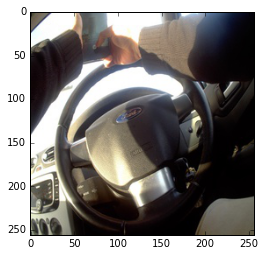

In [5]:
from scipy import misc
import random

def disp_preds(net, labels, image_path):
    """This function recieves a net and an image_path, and returns the top 5 prediction"""
    plt.imshow(misc.imread(image_path))
    im = caffe.io.load_image(image_path)
    net.blobs['data'].data[...] = transformer.preprocess('data', im)
    out = net.forward()
    layer = 'prob'
    if not layer in net.blobs:
        layer = 'probs'
    top_5 = np.sort(net.blobs[layer].data[0].flatten())[-1:-6:-1]
    top_5_index = net.blobs[layer].data[0].flatten().argsort()[-1:-6:-1]
    for i in range(len(top_5_index)):
        print "%.0f%%: %s"%( top_5[i] * 100., labels[top_5_index[i]])
        

def disp_pred(net, labels, image_path):
    """This function recieves a net and an image_path, and returns the top 5 prediction"""
    plt.imshow(misc.imread(image_path))
    im = caffe.io.load_image(image_path)
    net.blobs['data'].data[...] = transformer.preprocess('data', im)
    out = net.forward()
    layer = 'prob'
    if not layer in net.blobs:
        layer = 'probs'
    top = np.sort(net.blobs[layer].data[0].flatten())[-1]
    top_index = net.blobs[layer].data[0].flatten().argsort()[-1]
    print "%.0f%%: %s"%( top * 100., labels[top_index])


index = random.randint(0, len(test_paths))
print "Label: ", labels[test_labels[index]]
print "\nBest prediction"
disp_pred(activitiesnet, labels,  test_paths[index])
print "\nBest 5 predictions"
disp_preds(activitiesnet, labels,  test_paths[index])

Now we will splitt the test dataset into cattegories, to test all of them alone

In [5]:
paths = [[] for _ in range(NUM_LABELS)]
# each index index paths will contain a list of  pictures associated to a category
for i, path in enumerate(test_paths):
    paths[test_labels[i]].append(path)

# number of images per category
print [len(examples) for examples in paths]

[128, 150, 168, 160, 38, 131, 158, 127, 147, 118, 140, 134, 151, 114, 158, 45, 134, 149, 154, 149, 143]


Let's show a plot with the numer of images per category

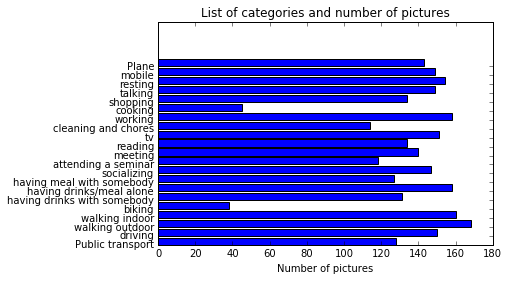

In [6]:
y_pos = np.arange(NUM_LABELS)
num_examples = [len(examples) for examples in paths]
plt.barh(y_pos, num_examples,  alpha=1)
plt.yticks(y_pos, labels)
plt.xlabel('Number of pictures')
plt.title('List of categories and number of pictures')
plt.show()

Let's test the accuracy for each category

In [7]:
def eval_category(net, category, label, layer='probs'):
    correct = 0.
    for path in category:
        processed_image = im = caffe.io.load_image(path)
        net.blobs['data'].data[...] = transformer.preprocess('data', processed_image)
        out = net.forward()
        top_label = net.blobs[layer].data[0].flatten().argsort()[-1]
        if top_label == label:
            correct += 1
    return correct / len(category)
        
def eval_categories(net, categories):
    """evaluates the net"""
    accuracies = np.zeros(len(categories))
    for i, category in enumerate(categories):
        accuracies[i] = eval_category(net,category, i )
    return accuracies * 100

accuracies = eval_categories(activitiesnet, paths)

In [8]:
for i, acc in enumerate(accuracies):
    print "%s: %i" %(labels[i], acc)

Public transport: 41
driving: 88
walking outdoor: 82
walking indoor: 33
biking: 18
having drinks with somebody: 53
having drinks/meal alone: 60
having meal with somebody: 44
socializing: 48
attending a seminar: 69
meeting: 27
reading: 79
tv: 86
cleaning and chores: 43
working: 73
cooking: 44
shopping: 61
talking: 59
resting: 86
mobile: 75
Plane: 74


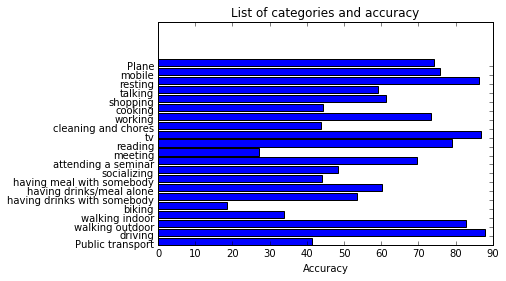

In [9]:
y_pos = np.arange(NUM_LABELS)
plt.barh(y_pos, accuracies,  alpha=1)
plt.yticks(y_pos, labels)
plt.xlabel('Accuracy')
plt.title('List of categories and accuracy')
plt.show()

In [10]:
def eval_global(net, paths, labels, layer='probs'):
    top_labels = np.zeros((len(paths)))
    for i, path in enumerate(paths):
        processed_image = im = caffe.io.load_image(path)
        net.blobs['data'].data[...] = transformer.preprocess('data', processed_image)
        out = net.forward()
        top_labels[i] = net.blobs[layer].data[0].flatten().argsort()[-1]
        
    return np.count_nonzero(top_labels == labels) / float(len(paths)) * 100., top_labels



def show_confusion_matrix(true_labels, top_labels, labels):
    # confusion matrix
    matrix = confusion_matrix(true_labels, top_labels)
    # normalize confutsion matrix
    num_per_class , _ = np.histogram(test_labels, len(labels))
    for i, row in enumerate(matrix):
        matrix[i] = matrix[i] * 100.  / num_per_class[i]
    
    

    norm_conf = []
    for i in matrix:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize=(10,7))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.GnBu, 
                    interpolation='nearest')

    width, height = matrix.shape

    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(matrix[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')

    cb = fig.colorbar(res)
    alphabet = labels
    ax.xaxis.tick_top()
    plt.xticks(range(width), alphabet[:width], rotation='vertical')
    plt.yticks(range(height), alphabet[:height])


In [11]:
glob_accuracy, top_labels = eval_global(activitiesnet, test_paths, test_labels)

Global accuracy of the cnn:  62% 


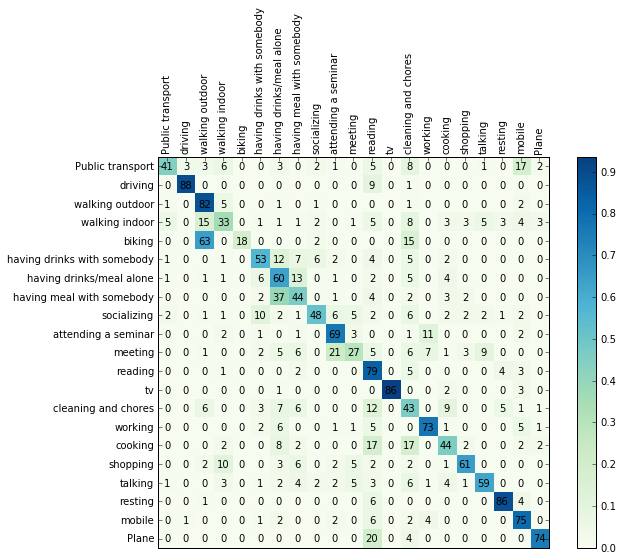

In [12]:
print "Global accuracy of the cnn:  %2.f%% " %(glob_accuracy)
show_confusion_matrix(test_labels, top_labels, labels)